# Static Simulations for Estimating the Testing Capacity Required to Safely Re-open Cornell
The goal of this notebook is to provide an initial answer the following questions:

* Assuming individual pcr testing, what would be the capacity of tests required per capita (student), and the testing frequency, necessary to limit the transmission rate to close to 1 (say 1.1 or 1.2)? Since these parameters are not independent, if you could try to optimize these with some assumptions about prevalence and false negatives.

* The same thing for group testing, but optimizing group sizes and determining test capacity and frequency.

In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src")
    
from population import Population
from group_testing import HouseholdGroupTest
from static_simulation import StaticSimulation
from frequency import frequency



In [20]:
doubling_time = 3.0
alpha = 2 ** (1/doubling_time)

# ignore inter-household correlation among cornell students
cornell_household_dist=[1]
SAR = 0.374 # secondary attack rate is not relevant if household sizes are all 1

beta = 1

FNR = 0.3
FPR = 0.0

# https://www.cornell.edu/about/facts.cfm
cornellpop = 24027

initial_prevalences = [0.01, 0.001, 0.0001]

reopen_pcts = [0.25,0.5,0.75,1]

group_sizes = [1,50, 100, 200]

## Simulate Resource Usage Across a number of Parameters


In [23]:
for reopen_pct in reopen_pcts:
    print(int(reopen_pct * cornellpop))

6006
12013
18020
24027


In [8]:
static_sim_results = {}
for prevalence in initial_prevalences:
    for reopen_pct in reopen_pcts:
        for group_size in group_sizes:
            n_students = int(reopen_pct * cornellpop)
            pop = Population(n_households=n_students, # Should be big relative to the largest group size
                          household_size_dist=cornell_household_dist,
                          target_prevalence=prevalence,
                          disease_length=0,
                          time_until_symptomatic=0,
                          non_quarantine_alpha=alpha,
                          daily_secondary_attack_rate=SAR,
                          fatality_pct=0,
                          daily_outside_infection_pct=0,
                          outside_symptomatic_prob=0,
                          initial_quarantine=0,
                          initial_prevalence=prevalence)
            test = HouseholdGroupTest(group_size,1,FNR,FPR)
            QFNR, QFPR, tests_per_person, quarantines_per_person = StaticSimulation(pop,test).sim(nreps=100)
            static_sim_results[(prevalence, reopen_pct, group_size)] = {
                'QFNR': QFNR, 'QFPR': QFPR, 'tests_per_person':tests_per_person, 
                'total_tests': tests_per_person * n_students, 'quarantines_per_person': quarantines_per_person,
                'total_quarantines': quarantines_per_person * n_students,
                'test_frequency_alpha': frequency(QFNR, alpha, beta),
                'test_frequency_alpha^1.25': frequency(QFNR, alpha**1.25, beta),
                'test_frequency_alpha^1.5':frequency(QFNR,alpha**1.5,beta)
            }
            print("Done static sims for prevalence {} and pct {} and group size {}".format(prevalence, reopen_pct, group_size))


Done static sims for prevalence 0.01 and pct 0.25 and group size 1
Done static sims for prevalence 0.01 and pct 0.25 and group size 50
Done static sims for prevalence 0.01 and pct 0.25 and group size 100
Done static sims for prevalence 0.01 and pct 0.25 and group size 200
Done static sims for prevalence 0.01 and pct 0.5 and group size 1
Done static sims for prevalence 0.01 and pct 0.5 and group size 50
Done static sims for prevalence 0.01 and pct 0.5 and group size 100
Done static sims for prevalence 0.01 and pct 0.5 and group size 200
Done static sims for prevalence 0.01 and pct 0.75 and group size 1
Done static sims for prevalence 0.01 and pct 0.75 and group size 50
Done static sims for prevalence 0.01 and pct 0.75 and group size 100
Done static sims for prevalence 0.01 and pct 0.75 and group size 200
Done static sims for prevalence 0.01 and pct 1 and group size 1
Done static sims for prevalence 0.01 and pct 1 and group size 50
Done static sims for prevalence 0.01 and pct 1 and group

In [22]:
static_sim_results

{(0.0001, 0.25, 1): {'QFNR': 0.3516666666666666,
  'QFPR': 0.0,
  'quarantines_per_person': 0.00014652014652014652,
  'test_frequency_alpha': 4.523158505366087,
  'test_frequency_alpha^1.25': 3.6185268042928698,
  'test_frequency_alpha^1.5': 3.015439003577391,
  'tests_per_person': 1.0,
  'total_quarantines': 0.88,
  'total_tests': 6006.0},
 (0.0001, 0.25, 50): {'QFNR': 0.25666666666666665,
  'QFPR': 0.008258928716948354,
  'quarantines_per_person': 0.008426573426573427,
  'test_frequency_alpha': 5.886096449402938,
  'test_frequency_alpha^1.25': 4.708877159522351,
  'test_frequency_alpha^1.5': 3.924064299601959,
  'tests_per_person': 0.020146520146520148,
  'total_quarantines': 50.61000000000001,
  'total_tests': 121.00000000000001},
 (0.0001, 0.25, 100): {'QFNR': 0.33333333333333326,
  'QFPR': 0.015275725301567797,
  'quarantines_per_person': 0.015427905427905427,
  'test_frequency_alpha': 4.75488750216347,
  'test_frequency_alpha^1.25': 3.803910001730776,
  'test_frequency_alpha^1.5'

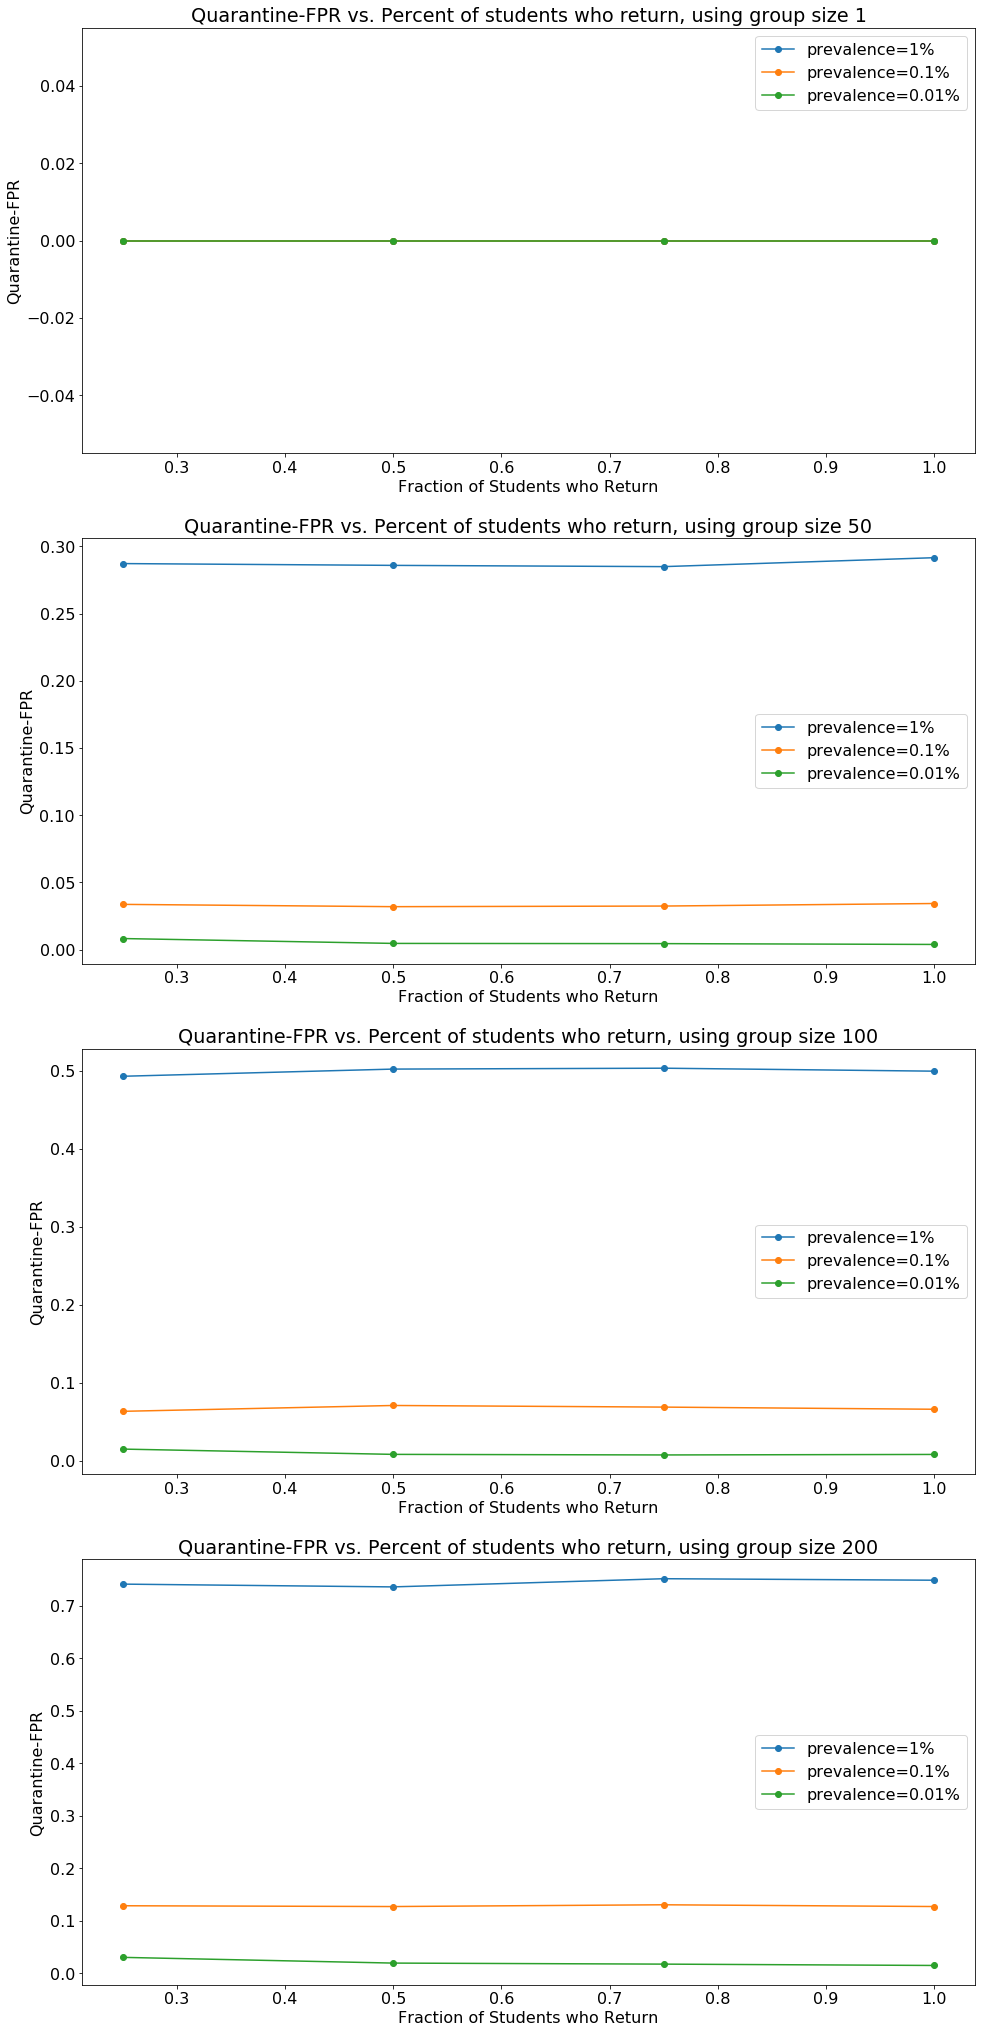

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))

doubling_time = 3.0
alpha = 2 ** (1/doubling_time)

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Quarantine-FPR vs. Percent of students who return, using group size {}".format(group_size))
    
    for prevalence in initial_prevalences:

        monthly_tests = []

        for reopen_pct in reopen_pcts:
            qfpr = static_sim_results[(prevalence, reopen_pct, group_size)]['QFPR']

            monthly_tests.append(qfpr)

        plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}".format(
            prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Quarantine-FPR")

    plt.legend(loc='best')

        
    


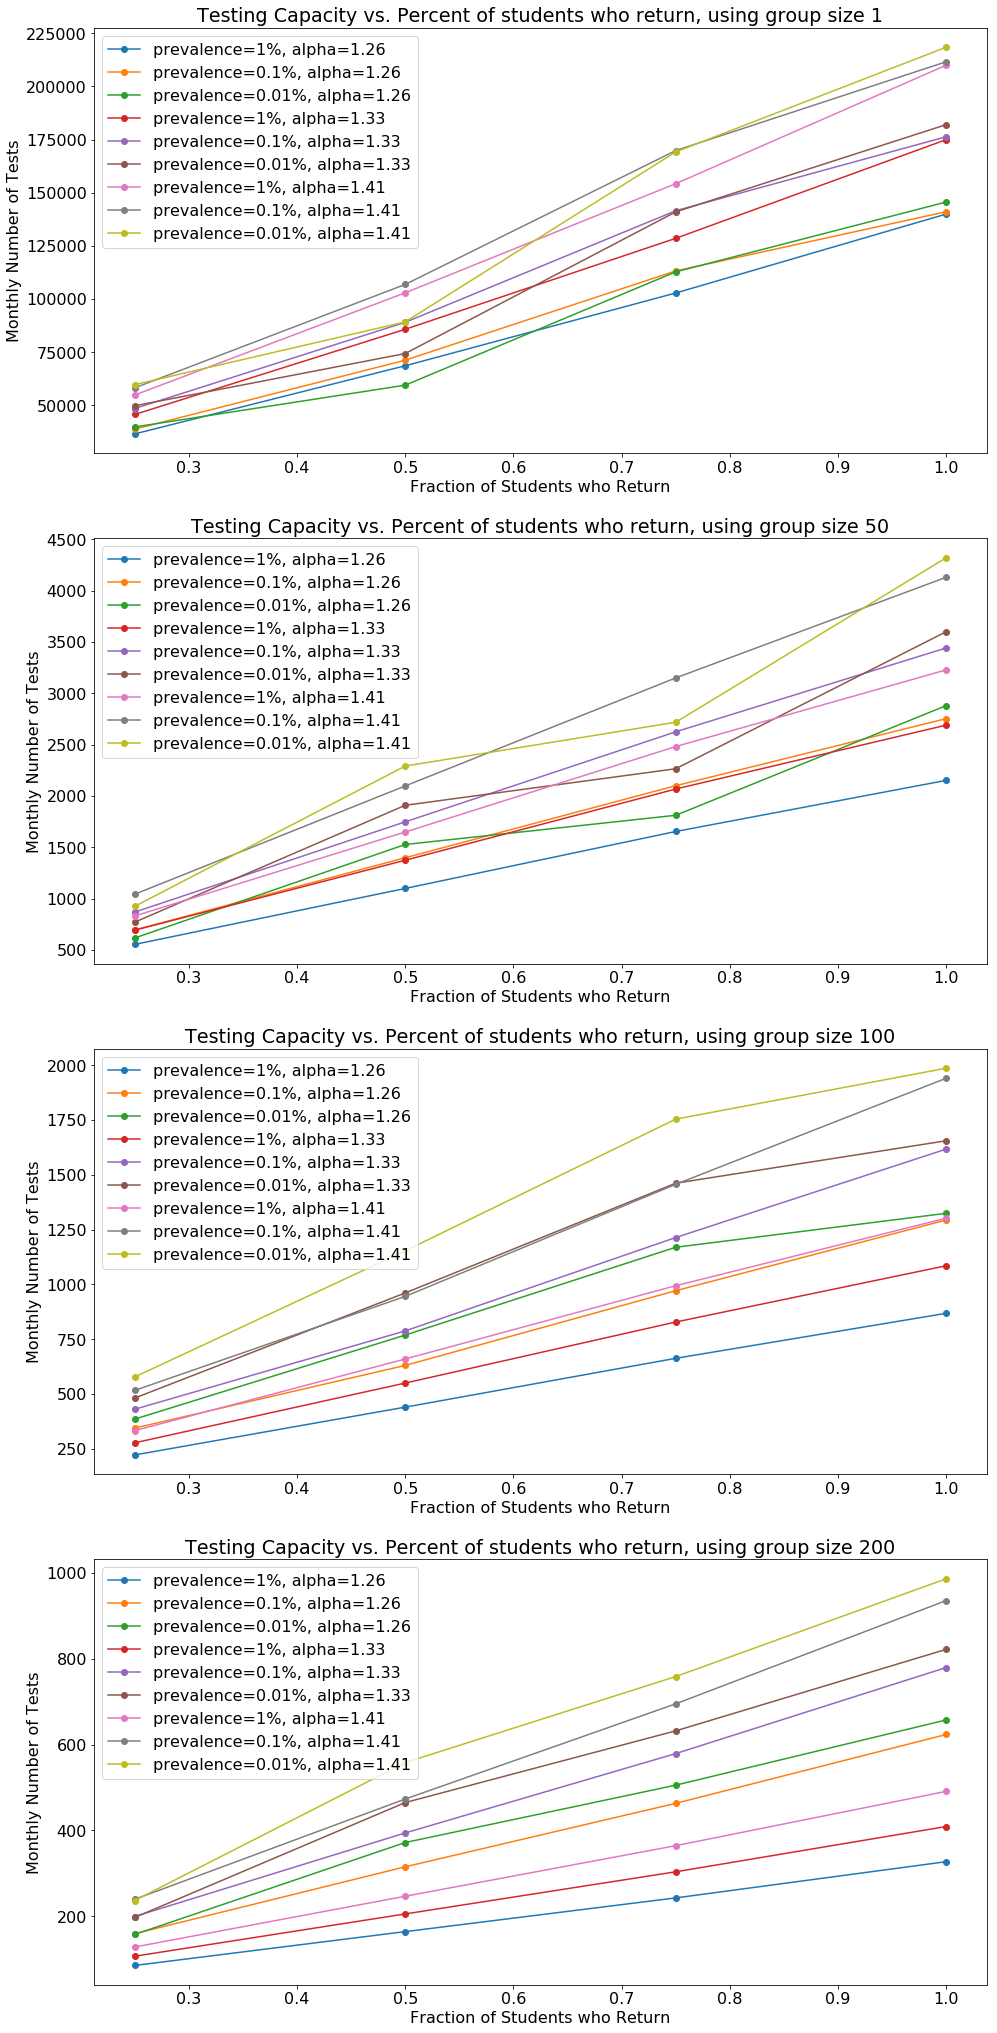

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Capacity vs. Percent of students who return, using group size {}".format(group_size))
    for alpha, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]
                test_magnitude = static_sim_results[(prevalence, reopen_pct, group_size)]['total_tests']

                monthly_tests.append(test_magnitude * 30 / test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Monthly Number of Tests")

    plt.legend(loc='best')

        
    


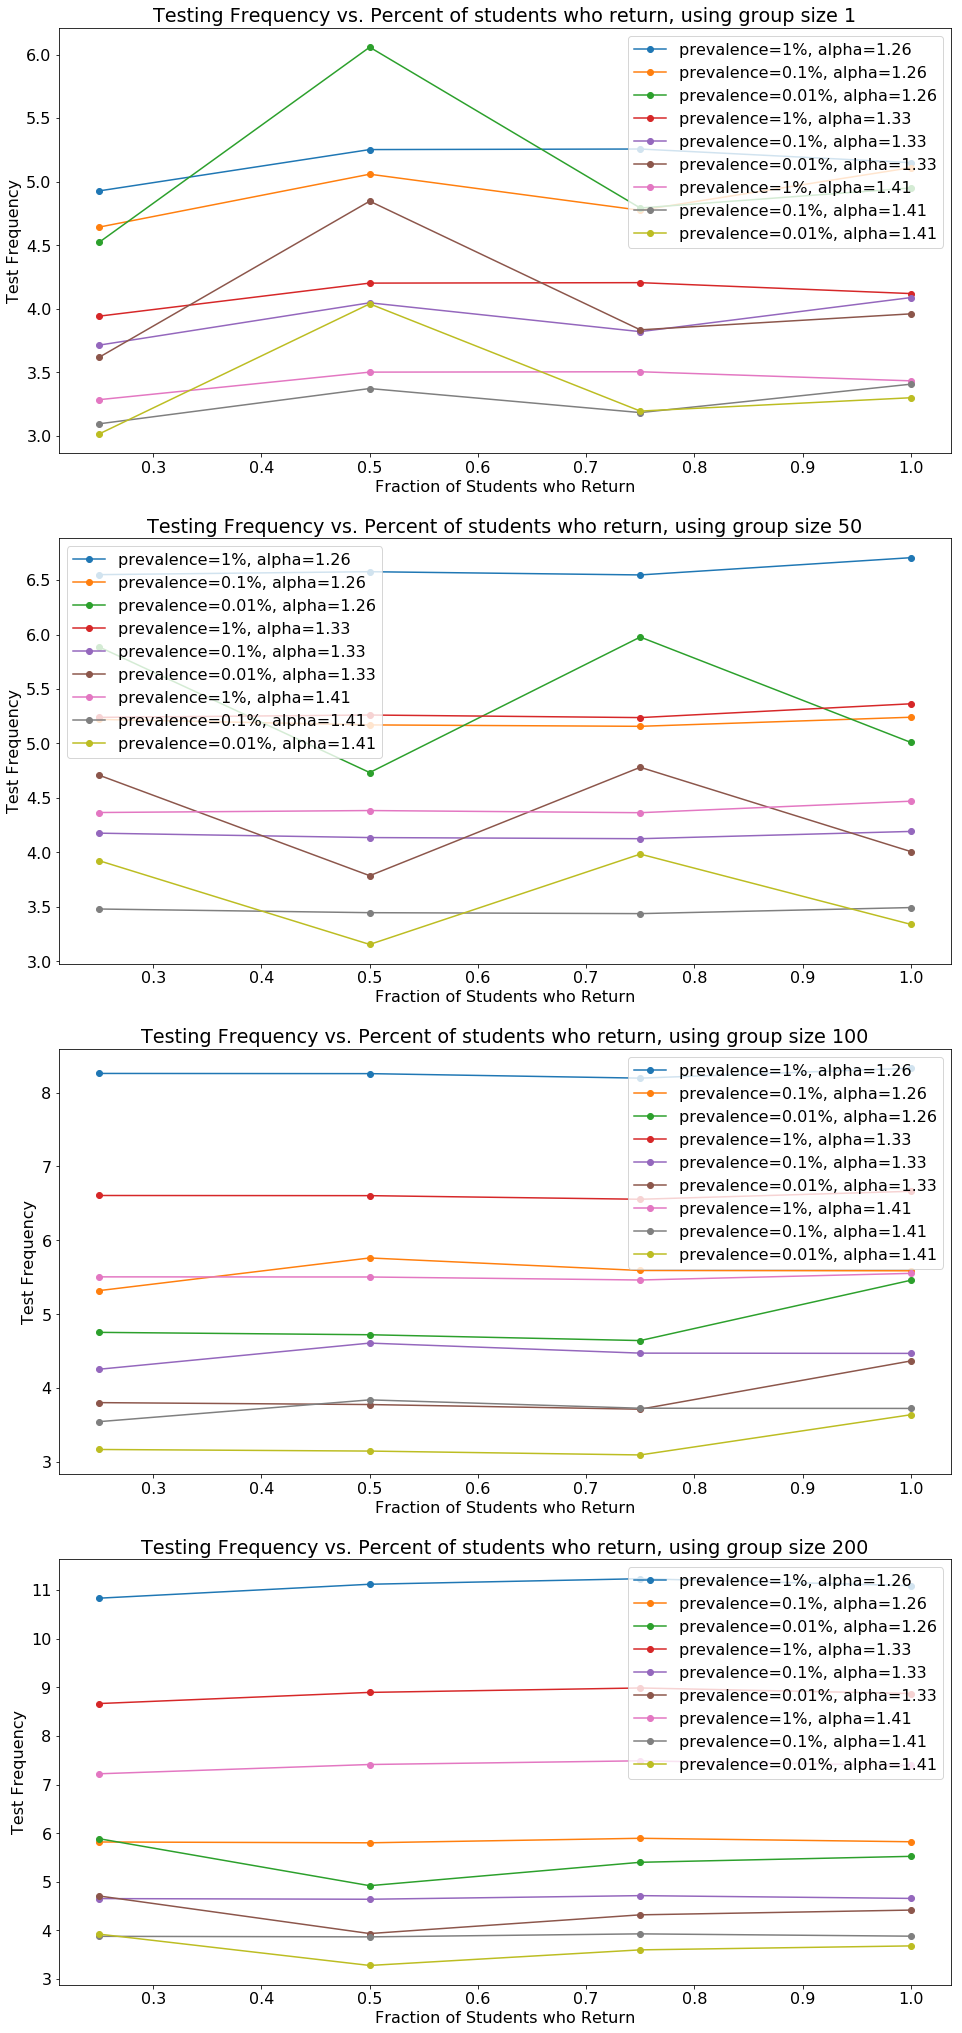

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16

alpha = 2 ** (1/3.0)
plt.figure(figsize=(16,36))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Frequency vs. Percent of students who return, using group size {}".format(group_size))
    for alpha, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]

                monthly_tests.append(test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Test Frequency")

    plt.legend(loc='best')

        
    


In [24]:
static_sim_results_copy = static_sim_results.copy()

In [25]:
from group_testing import MatrixGroupTest
from math import sqrt

mtx_static_sim_results = {}
for prevalence in initial_prevalences:
    for reopen_pct in reopen_pcts:
        for group_size in group_sizes:
            n_students = int(reopen_pct * cornellpop)
            pop = Population(n_households=n_students, # Should be big relative to the largest group size
                          household_size_dist=cornell_household_dist,
                          target_prevalence=prevalence,
                          disease_length=0,
                          time_until_symptomatic=0,
                          non_quarantine_alpha=alpha,
                          daily_secondary_attack_rate=SAR,
                          fatality_pct=0,
                          daily_outside_infection_pct=0,
                          outside_symptomatic_prob=0,
                          initial_quarantine=0,
                          initial_prevalence=prevalence)
            test = MatrixGroupTest(int(sqrt(group_size)),FNR,FPR, fnr_at_swab_level=True)
            QFNR, QFPR, tests_per_person, quarantines_per_person = StaticSimulation(pop,test).sim(nreps=100)
            mtx_static_sim_results[(prevalence, reopen_pct, group_size)] = {
                'QFNR': QFNR, 'QFPR': QFPR, 'tests_per_person':tests_per_person, 
                'total_tests': tests_per_person * n_students, 'quarantines_per_person': quarantines_per_person,
                'total_quarantines': quarantines_per_person * n_students,
                'test_frequency_alpha': frequency(QFNR, alpha, beta),
                'test_frequency_alpha^1.25': frequency(QFNR, alpha**1.25, beta),
                'test_frequency_alpha^1.5':frequency(QFNR,alpha**1.5,beta)
            }
            print("Done static sims for prevalence {} and pct {} and group size {}".format(prevalence, reopen_pct, group_size))


Done static sims for prevalence 0.01 and pct 0.25 and group size 1
Done static sims for prevalence 0.01 and pct 0.25 and group size 50
Done static sims for prevalence 0.01 and pct 0.25 and group size 100
Done static sims for prevalence 0.01 and pct 0.25 and group size 200
Done static sims for prevalence 0.01 and pct 0.5 and group size 1
Done static sims for prevalence 0.01 and pct 0.5 and group size 50
Done static sims for prevalence 0.01 and pct 0.5 and group size 100
Done static sims for prevalence 0.01 and pct 0.5 and group size 200
Done static sims for prevalence 0.01 and pct 0.75 and group size 1
Done static sims for prevalence 0.01 and pct 0.75 and group size 50
Done static sims for prevalence 0.01 and pct 0.75 and group size 100
Done static sims for prevalence 0.01 and pct 0.75 and group size 200
Done static sims for prevalence 0.01 and pct 1 and group size 1
Done static sims for prevalence 0.01 and pct 1 and group size 50
Done static sims for prevalence 0.01 and pct 1 and group

In [26]:
mtx_static_sim_results

{(0.0001, 0.25, 1): {'QFNR': 0.32666666666666666,
  'QFPR': 0.0,
  'quarantines_per_person': 0.00014985014985014985,
  'test_frequency_alpha': 3.2282176927613446,
  'test_frequency_alpha^1.25': 2.5825741542090754,
  'test_frequency_alpha^1.5': 2.1521451285075632,
  'tests_per_person': 2.0,
  'total_quarantines': 0.9,
  'total_tests': 12012.0},
 (0.0001, 0.25, 50): {'QFNR': 0.3483333333333333,
  'QFPR': 0.0,
  'quarantines_per_person': 0.00015484515484515485,
  'test_frequency_alpha': 3.0429191168299967,
  'test_frequency_alpha^1.25': 2.434335293463997,
  'test_frequency_alpha^1.5': 2.028612744553331,
  'tests_per_person': 0.2863802863802864,
  'total_quarantines': 0.93,
  'total_tests': 1720.0},
 (0.0001, 0.25, 100): {'QFNR': 0.2916666666666667,
  'QFPR': 3.331112591605596e-06,
  'quarantines_per_person': 0.00015318015318015318,
  'test_frequency_alpha': 3.555215157327104,
  'test_frequency_alpha^1.25': 2.8441721258616828,
  'test_frequency_alpha^1.5': 2.370143438218069,
  'tests_per_p

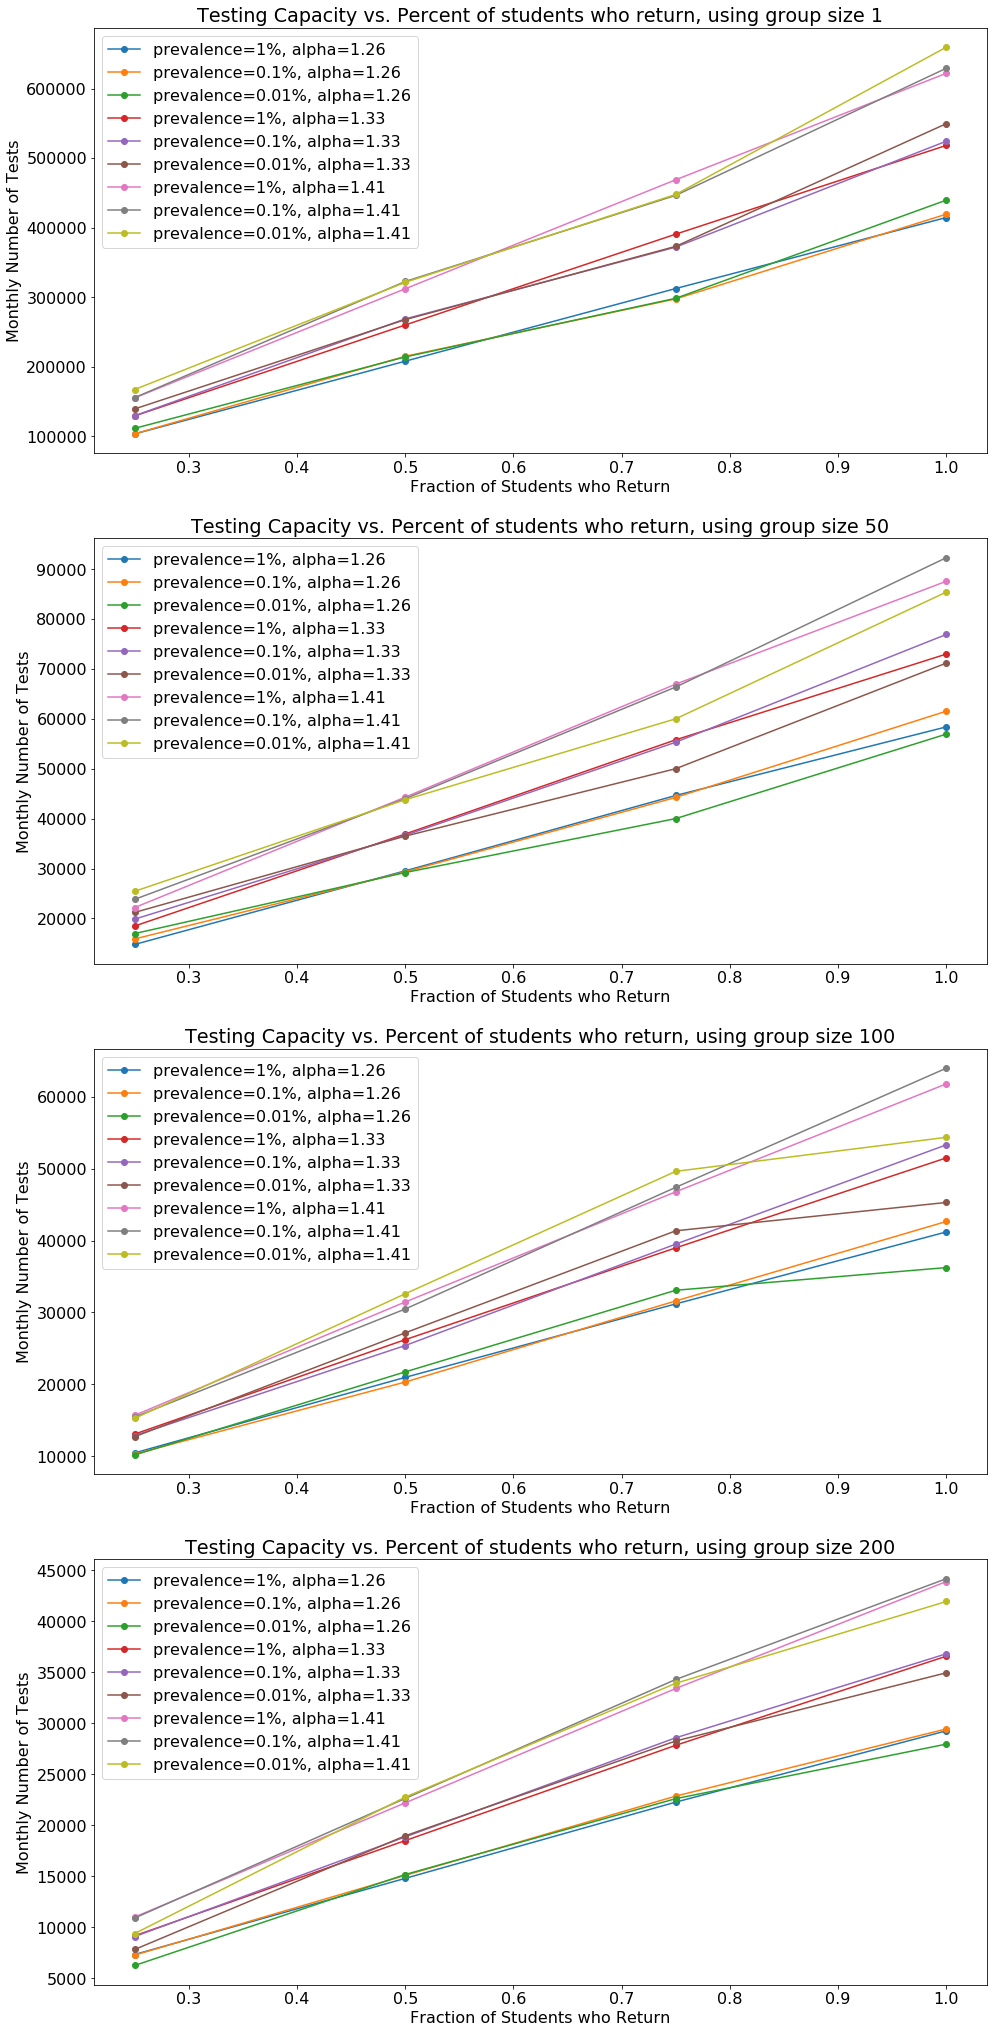

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16

alpha = 2 ** (1/3.0)

plt.figure(figsize=(16,36))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Capacity vs. Percent of students who return, using group size {}".format(group_size))
    for alpha, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = mtx_static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]
                test_magnitude = mtx_static_sim_results[(prevalence, reopen_pct, group_size)]['total_tests']

                monthly_tests.append(test_magnitude * 30 / test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Monthly Number of Tests")

    plt.legend(loc='best')

        
    


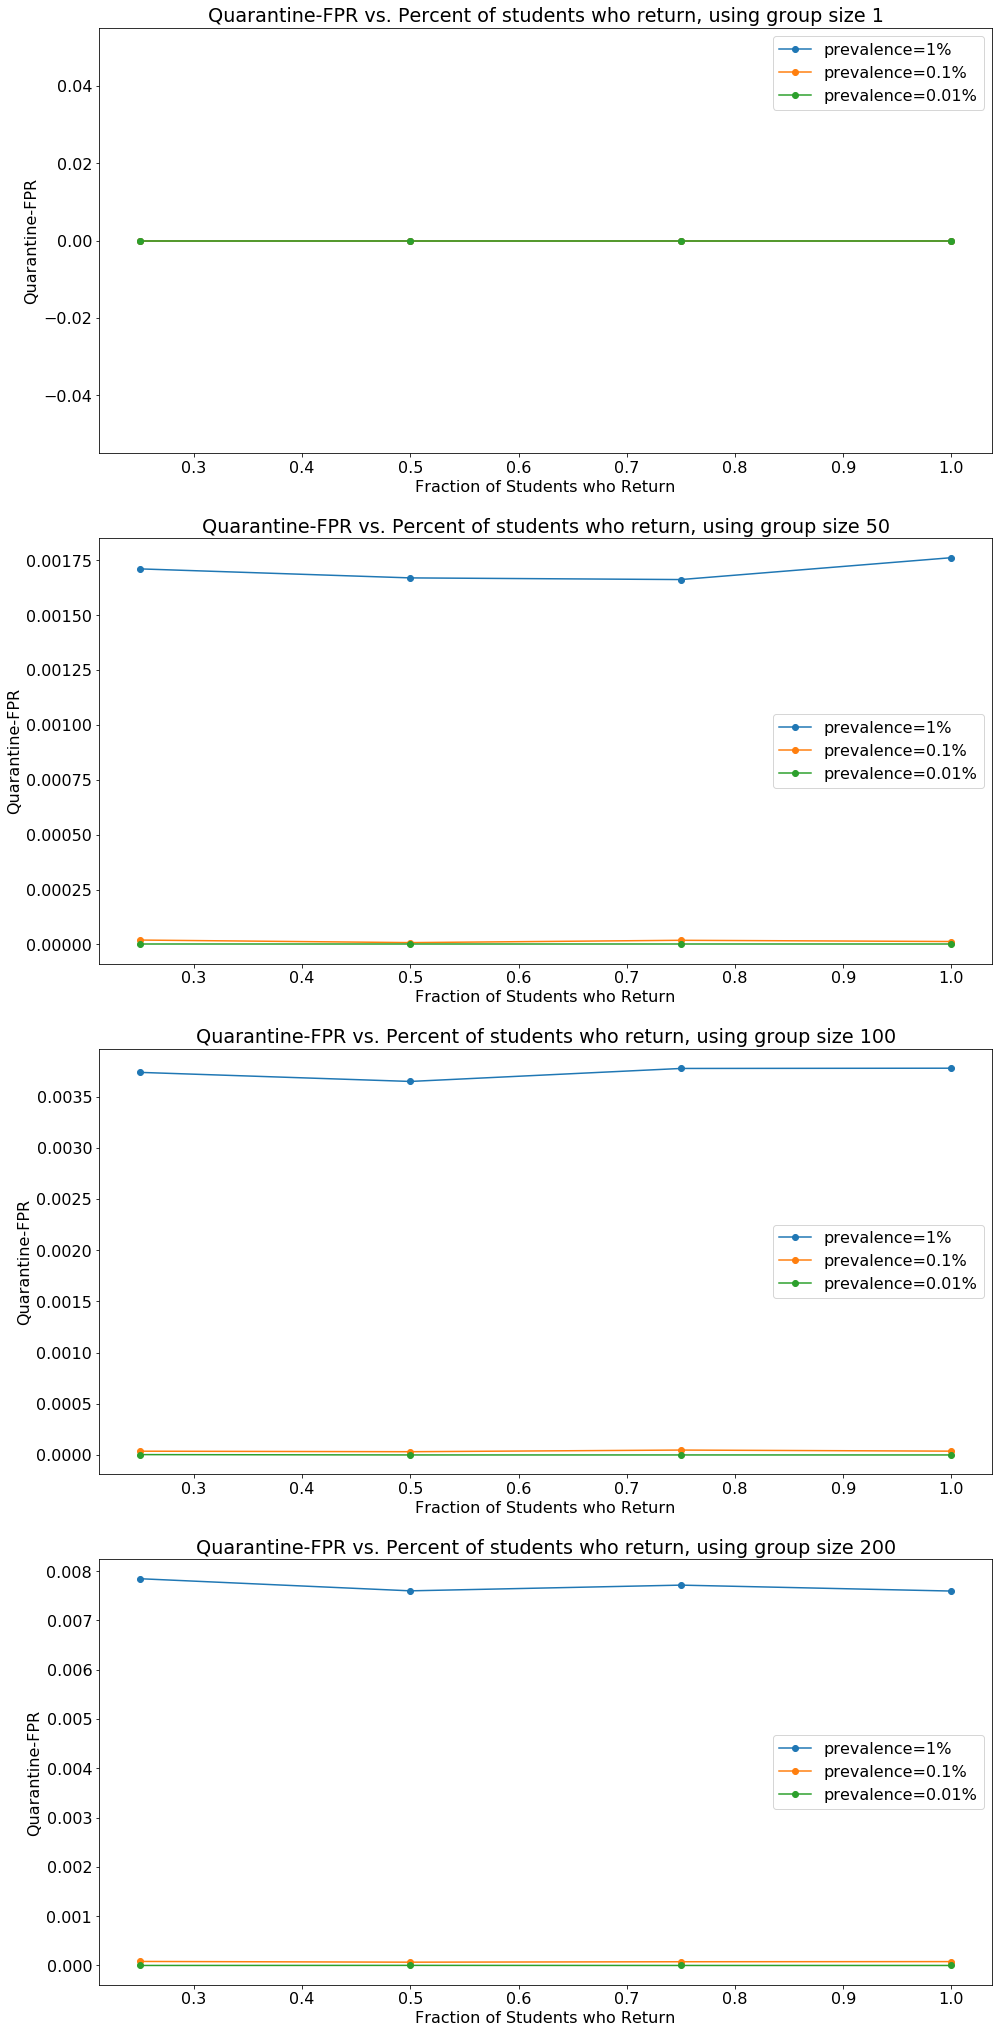

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))

doubling_time = 3.0
alpha = 2 ** (1/doubling_time)

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Quarantine-FPR vs. Percent of students who return, using group size {}".format(group_size))
    
    for prevalence in initial_prevalences:

        monthly_tests = []

        for reopen_pct in reopen_pcts:
            qfpr = mtx_static_sim_results[(prevalence, reopen_pct, group_size)]['QFPR']

            monthly_tests.append(qfpr)

        plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}".format(
            prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Quarantine-FPR")

    plt.legend(loc='best')

        
    


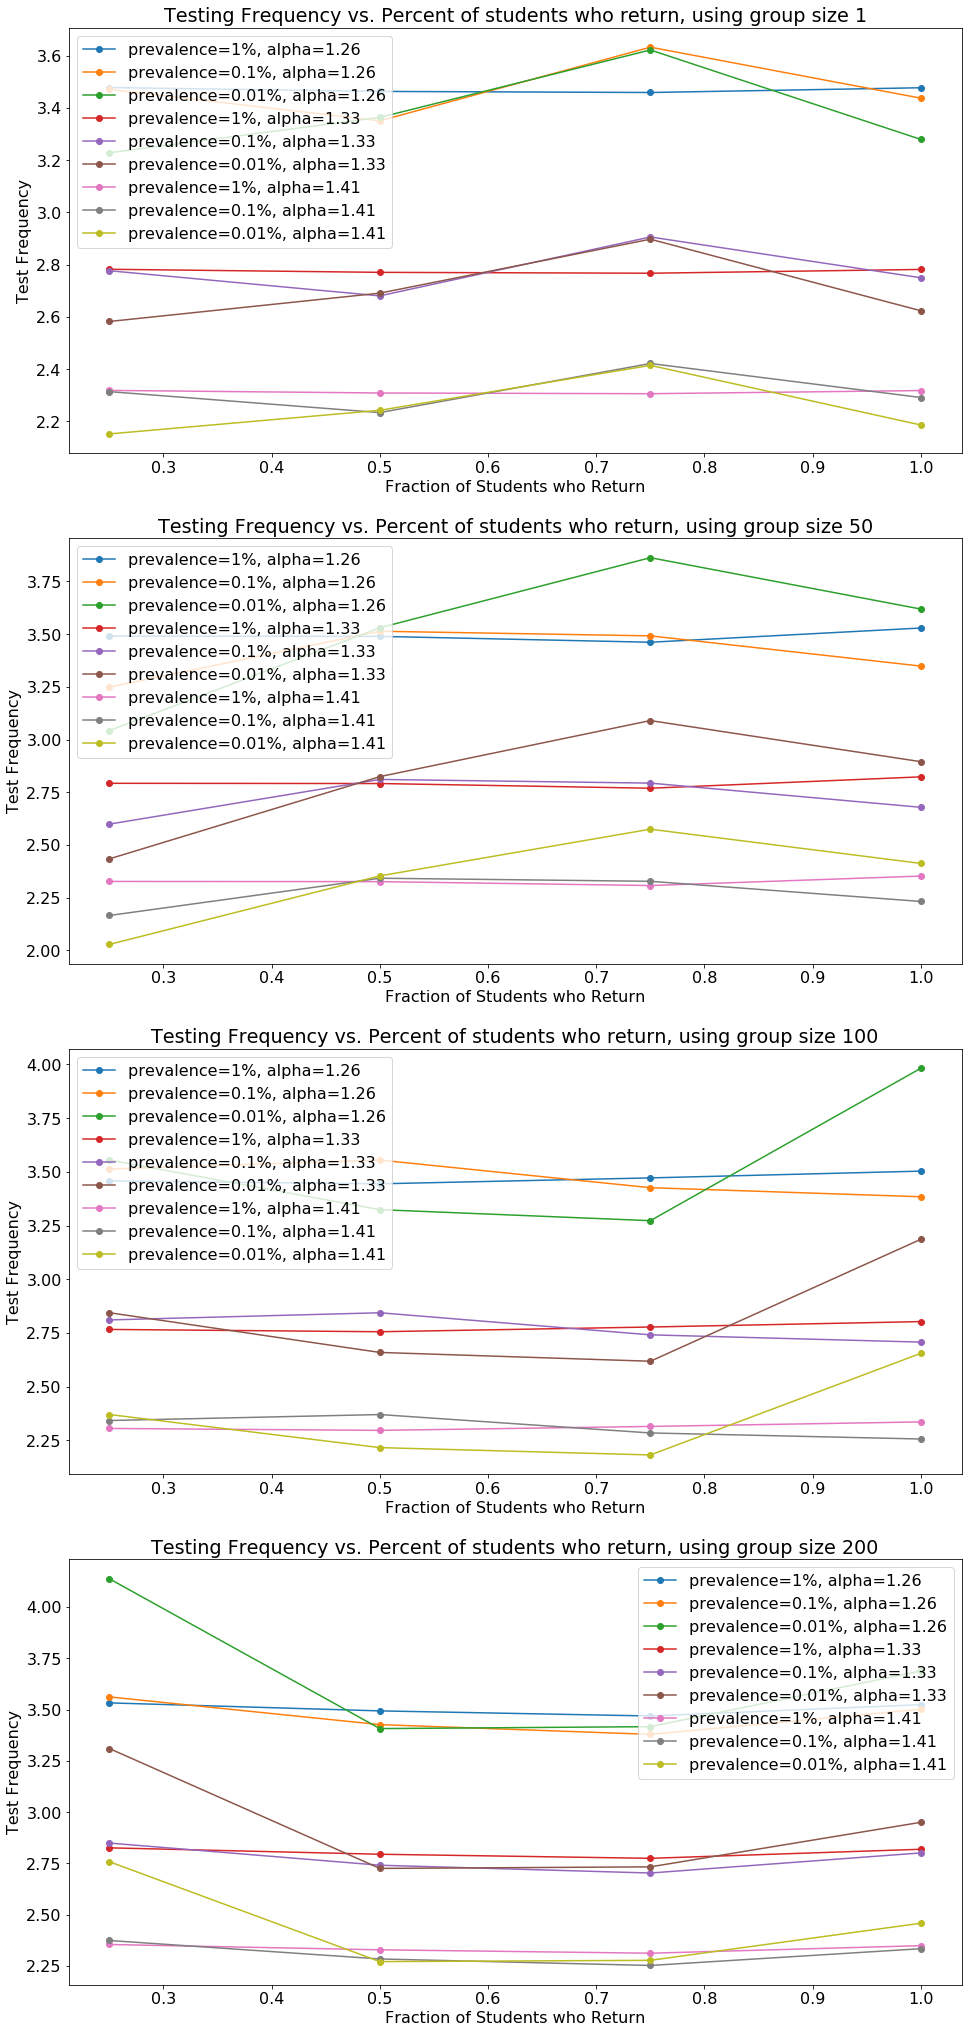

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16

alpha = 2 ** (1/3.0)
plt.figure(figsize=(16,36))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Frequency vs. Percent of students who return, using group size {}".format(group_size))
    for alpha, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = mtx_static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]

                monthly_tests.append(test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Test Frequency")

    plt.legend(loc='best')

        
    


In [31]:
from group_testing import MatrixGroupTest
from math import sqrt

big_mtx_static_sim_results = {}
big_group_sizes = [500, 1000, 5000, 10000]
for prevalence in initial_prevalences:
    for reopen_pct in reopen_pcts:
        for group_size in big_group_sizes:
            n_students = int(reopen_pct * cornellpop)
            pop = Population(n_households=n_students, # Should be big relative to the largest group size
                          household_size_dist=cornell_household_dist,
                          target_prevalence=prevalence,
                          disease_length=0,
                          time_until_symptomatic=0,
                          non_quarantine_alpha=alpha,
                          daily_secondary_attack_rate=SAR,
                          fatality_pct=0,
                          daily_outside_infection_pct=0,
                          outside_symptomatic_prob=0,
                          initial_quarantine=0,
                          initial_prevalence=prevalence)
            test = MatrixGroupTest(int(sqrt(group_size)),FNR,FPR, fnr_at_swab_level=True)
            QFNR, QFPR, tests_per_person, quarantines_per_person = StaticSimulation(pop,test).sim(nreps=100)
            big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)] = {
                'QFNR': QFNR, 'QFPR': QFPR, 'tests_per_person':tests_per_person, 
                'total_tests': tests_per_person * n_students, 'quarantines_per_person': quarantines_per_person,
                'total_quarantines': quarantines_per_person * n_students,
                'test_frequency_alpha': frequency(QFNR, alpha, beta),
                'test_frequency_alpha^1.25': frequency(QFNR, alpha**1.25, beta),
                'test_frequency_alpha^1.5':frequency(QFNR,alpha**1.5,beta)
            }
            print("Done static sims for prevalence {} and pct {} and group size {}".format(prevalence, reopen_pct, group_size))


Done static sims for prevalence 0.01 and pct 0.25 and group size 500
Done static sims for prevalence 0.01 and pct 0.25 and group size 1000
Done static sims for prevalence 0.01 and pct 0.25 and group size 5000
Done static sims for prevalence 0.01 and pct 0.25 and group size 10000
Done static sims for prevalence 0.01 and pct 0.5 and group size 500
Done static sims for prevalence 0.01 and pct 0.5 and group size 1000
Done static sims for prevalence 0.01 and pct 0.5 and group size 5000
Done static sims for prevalence 0.01 and pct 0.5 and group size 10000
Done static sims for prevalence 0.01 and pct 0.75 and group size 500
Done static sims for prevalence 0.01 and pct 0.75 and group size 1000
Done static sims for prevalence 0.01 and pct 0.75 and group size 5000
Done static sims for prevalence 0.01 and pct 0.75 and group size 10000
Done static sims for prevalence 0.01 and pct 1 and group size 500
Done static sims for prevalence 0.01 and pct 1 and group size 1000
Done static sims for prevalence

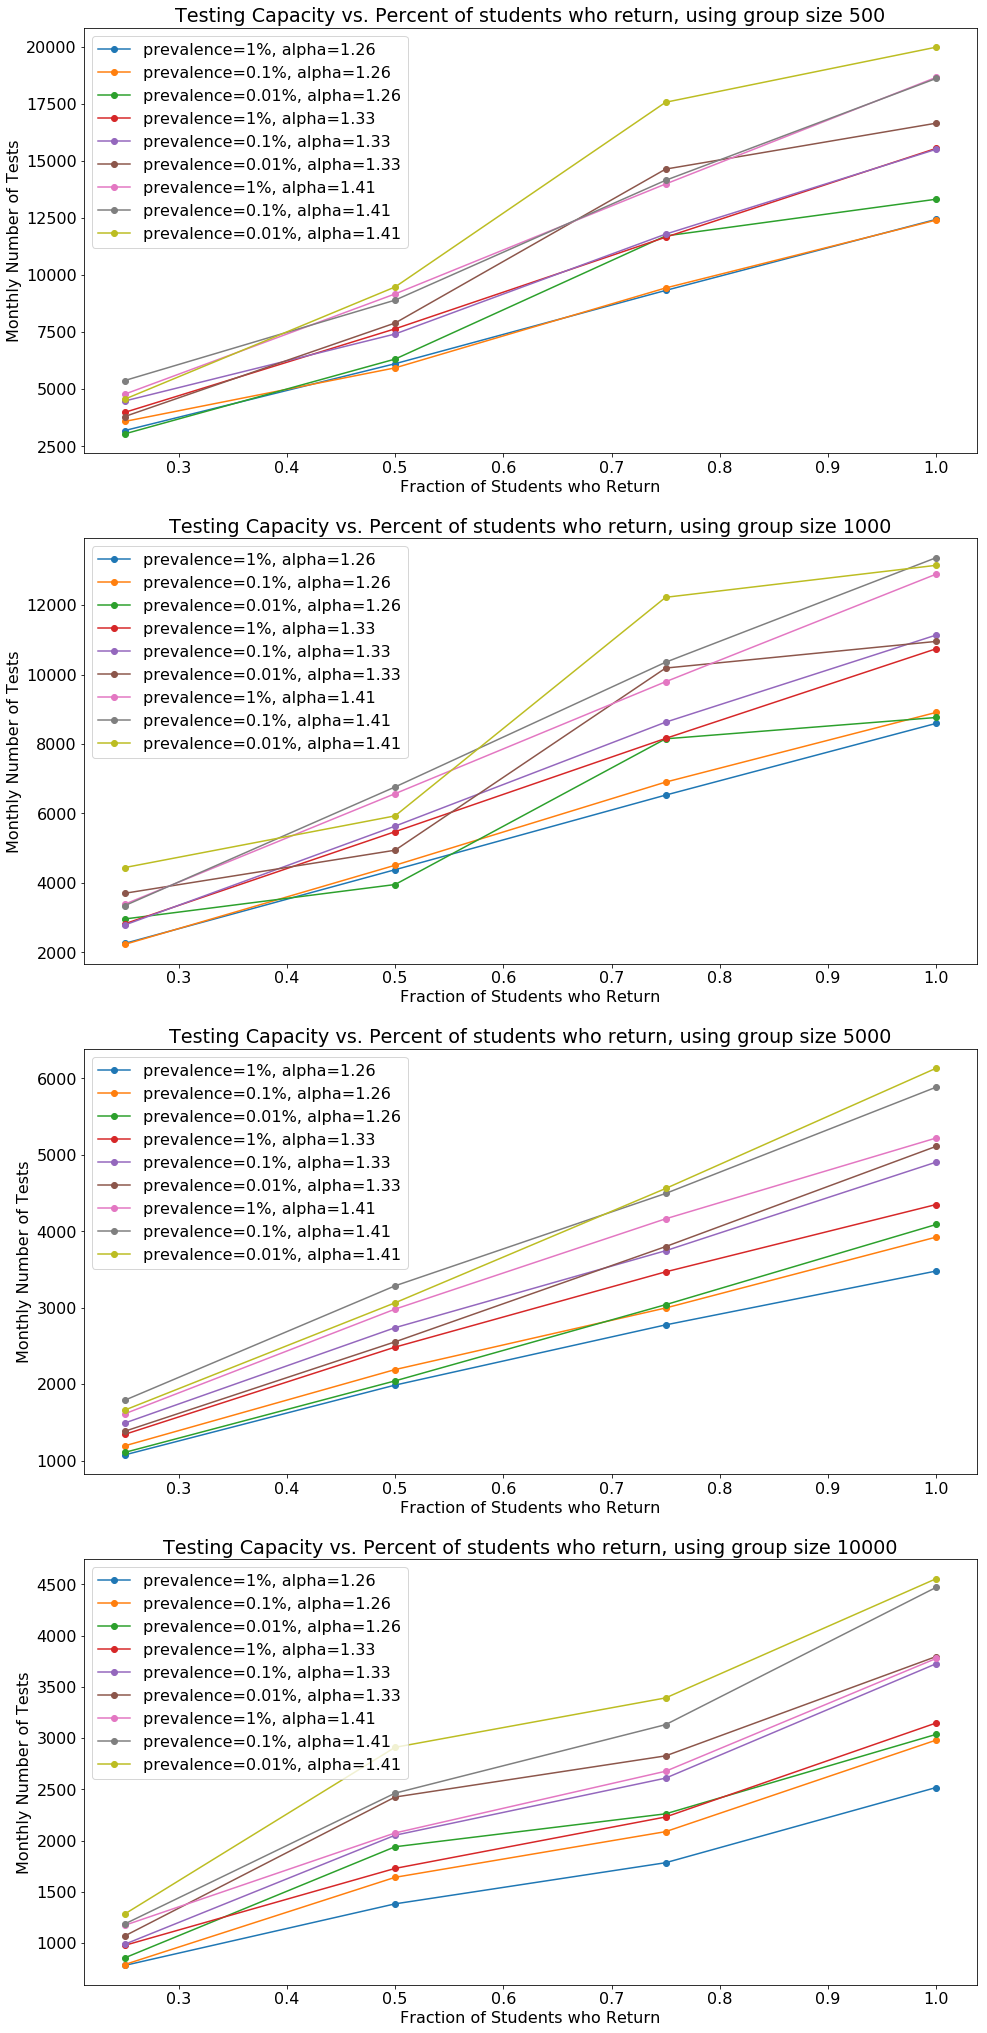

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in big_group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Capacity vs. Percent of students who return, using group size {}".format(group_size))
    for alpha, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]
                test_magnitude = big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)]['total_tests']

                monthly_tests.append(test_magnitude * 30 / test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Monthly Number of Tests")

    plt.legend(loc='best')

        
    


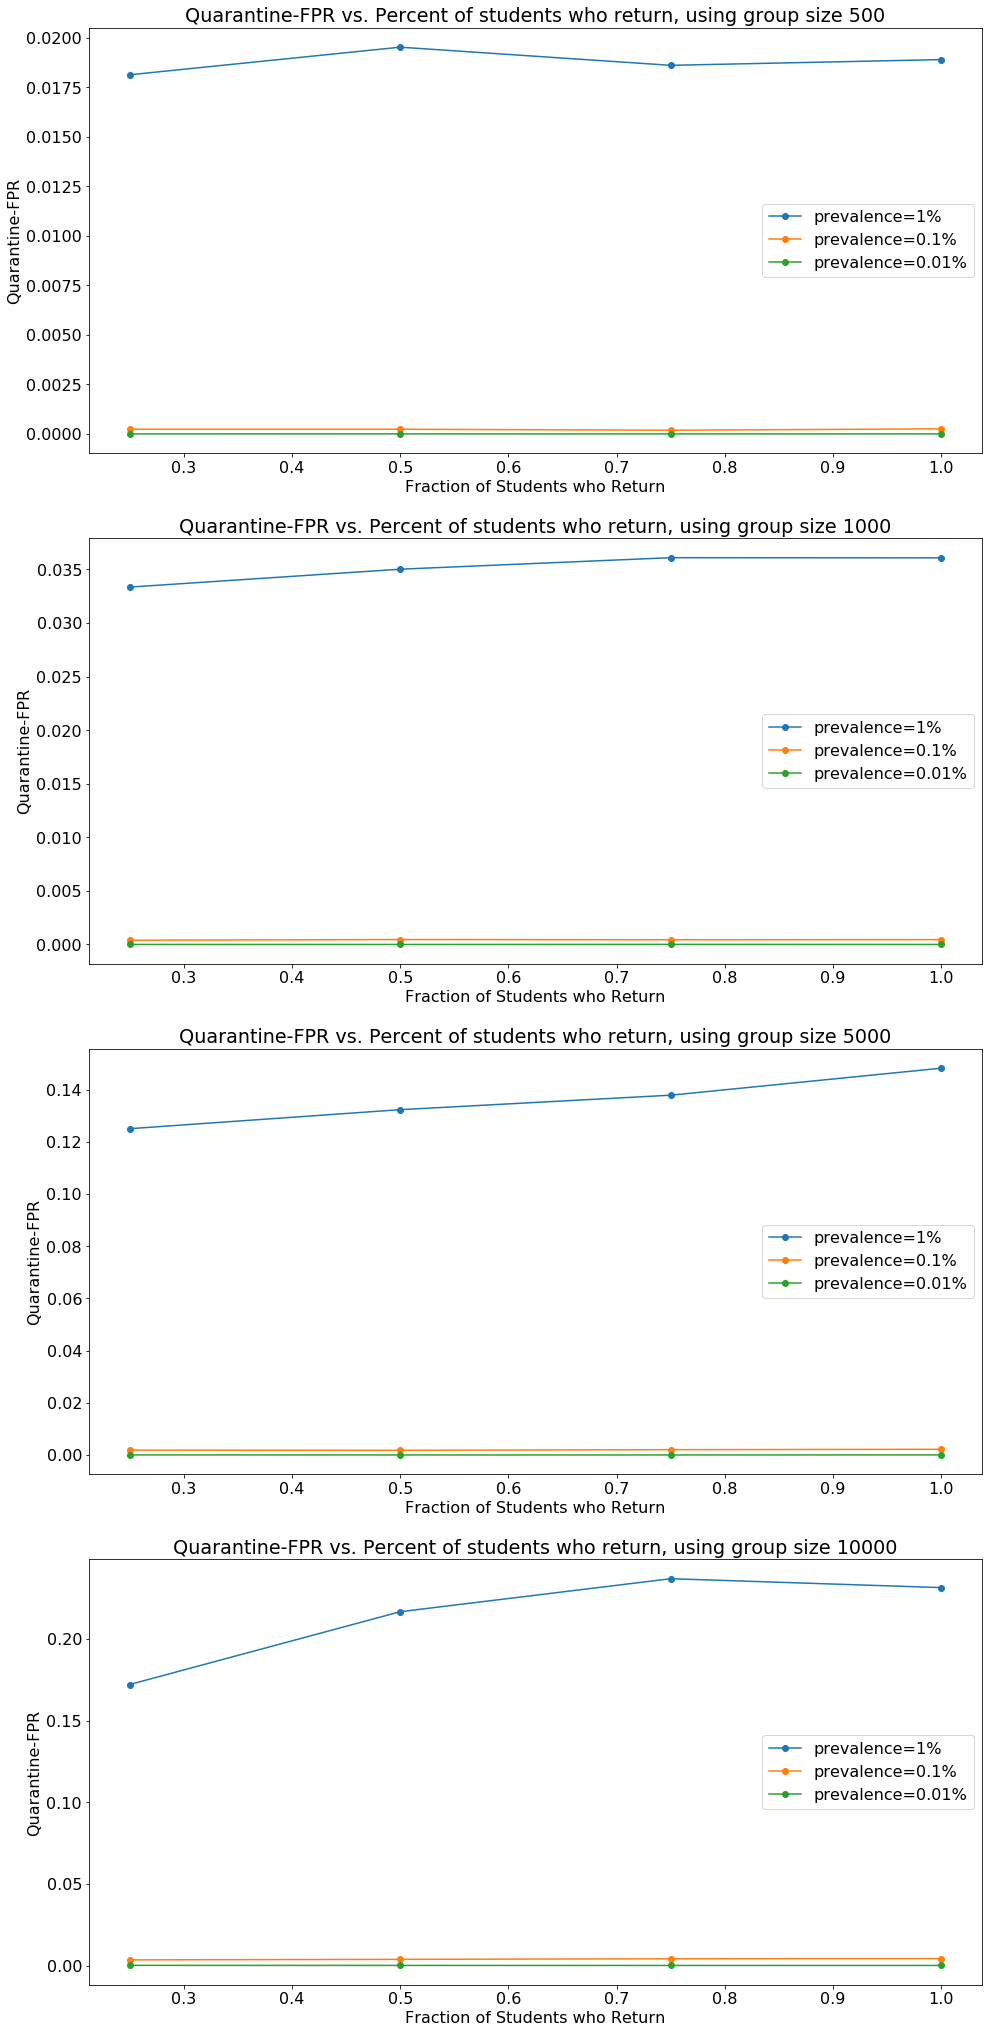

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))

doubling_time = 3.0
alpha = 2 ** (1/doubling_time)

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in big_group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Quarantine-FPR vs. Percent of students who return, using group size {}".format(group_size))
    
    for prevalence in initial_prevalences:

        monthly_tests = []

        for reopen_pct in reopen_pcts:
            qfpr = big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)]['QFPR']

            monthly_tests.append(qfpr)

        plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}".format(
            prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Quarantine-FPR")

    plt.legend(loc='best')

        
    


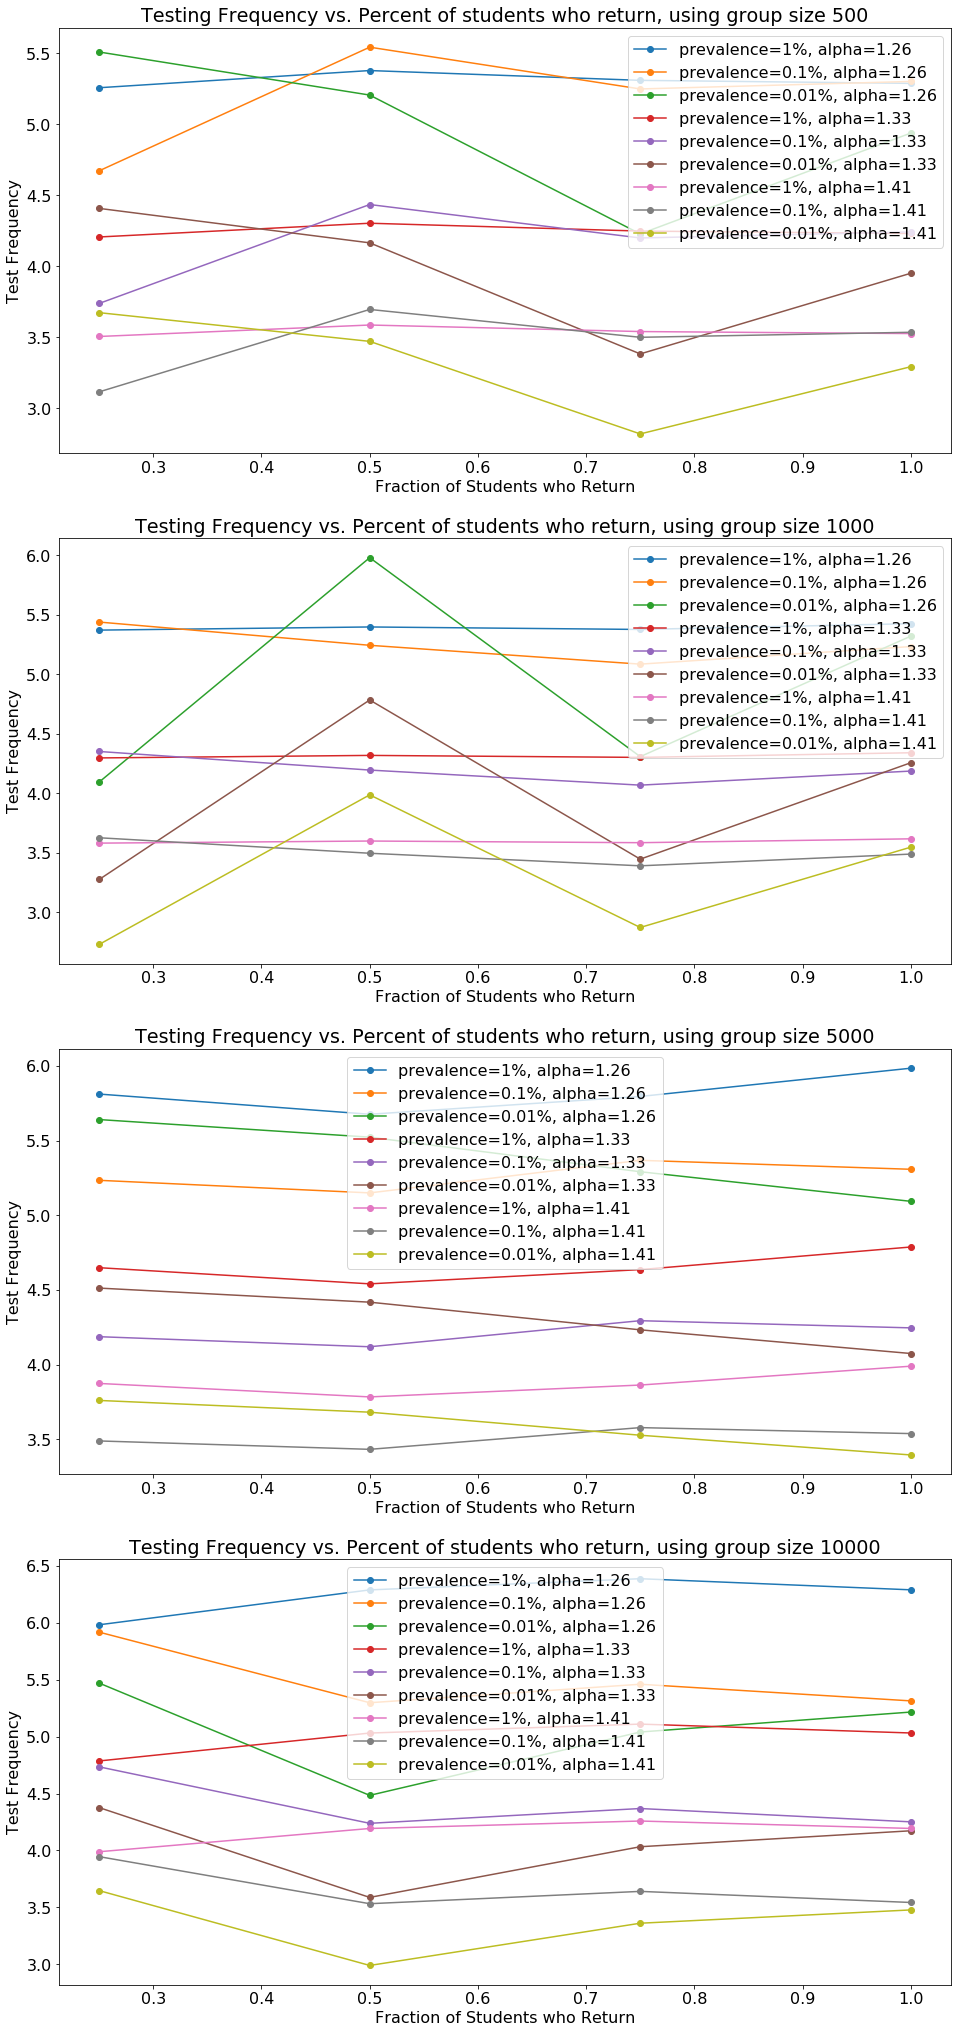

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in big_group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Frequency vs. Percent of students who return, using group size {}".format(group_size))
    for alpha, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]

                monthly_tests.append(test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha))

    plt.xlabel("Fraction of Students who Return")
    plt.ylabel("Test Frequency")

    plt.legend(loc='best')

        
    


# Update Resource simulations with population that includes faculty+staff+academic professionals

In [43]:
doubling_time = 3.0
alpha = 2 ** (1/doubling_time)

# ignore inter-household correlation among cornell students
cornell_household_dist=[1]
SAR = 0.374 # secondary attack rate is not relevant if household sizes are all 1

beta = 1

FNR = 0.3
FPR = 0.0

# https://www.cornell.edu/about/facts.cfm
studentpop = 24027 
staffpop = 10283
cornellpop = studentpop + staffpop

initial_prevalences = [0.01, 0.001, 0.0001]

reopen_pcts = [0.25,0.5,0.75,1]

In [44]:
fullpop_static_sim_results = {}
for prevalence in initial_prevalences:
    for reopen_pct in reopen_pcts:
        for group_size in [1]:
            n_students = int(reopen_pct * cornellpop)
            pop = Population(n_households=n_students, # Should be big relative to the largest group size
                          household_size_dist=cornell_household_dist,
                          target_prevalence=prevalence,
                          disease_length=0,
                          time_until_symptomatic=0,
                          non_quarantine_alpha=alpha,
                          daily_secondary_attack_rate=SAR,
                          fatality_pct=0,
                          daily_outside_infection_pct=0,
                          outside_symptomatic_prob=0,
                          initial_quarantine=0,
                          initial_prevalence=prevalence)
            test = HouseholdGroupTest(group_size,1,FNR,FPR)
            QFNR, QFPR, tests_per_person, quarantines_per_person = StaticSimulation(pop,test).sim(nreps=100)
            fullpop_static_sim_results[(prevalence, reopen_pct, group_size)] = {
                'QFNR': QFNR, 'QFPR': QFPR, 'tests_per_person':tests_per_person, 
                'total_tests': tests_per_person * n_students, 'quarantines_per_person': quarantines_per_person,
                'total_quarantines': quarantines_per_person * n_students,
                'test_frequency_alpha': frequency(QFNR, alpha, beta),
                'test_frequency_alpha^1.25': frequency(QFNR, alpha**1.25, beta),
                'test_frequency_alpha^1.5':frequency(QFNR,alpha**1.5,beta)
            }
            print("Done static sims for prevalence {} and pct {} and group size {}".format(prevalence, reopen_pct, group_size))


Done static sims for prevalence 0.01 and pct 0.25 and group size 1
Done static sims for prevalence 0.01 and pct 0.5 and group size 1
Done static sims for prevalence 0.01 and pct 0.75 and group size 1
Done static sims for prevalence 0.01 and pct 1 and group size 1
Done static sims for prevalence 0.001 and pct 0.25 and group size 1
Done static sims for prevalence 0.001 and pct 0.5 and group size 1
Done static sims for prevalence 0.001 and pct 0.75 and group size 1
Done static sims for prevalence 0.001 and pct 1 and group size 1
Done static sims for prevalence 0.0001 and pct 0.25 and group size 1
Done static sims for prevalence 0.0001 and pct 0.5 and group size 1
Done static sims for prevalence 0.0001 and pct 0.75 and group size 1
Done static sims for prevalence 0.0001 and pct 1 and group size 1


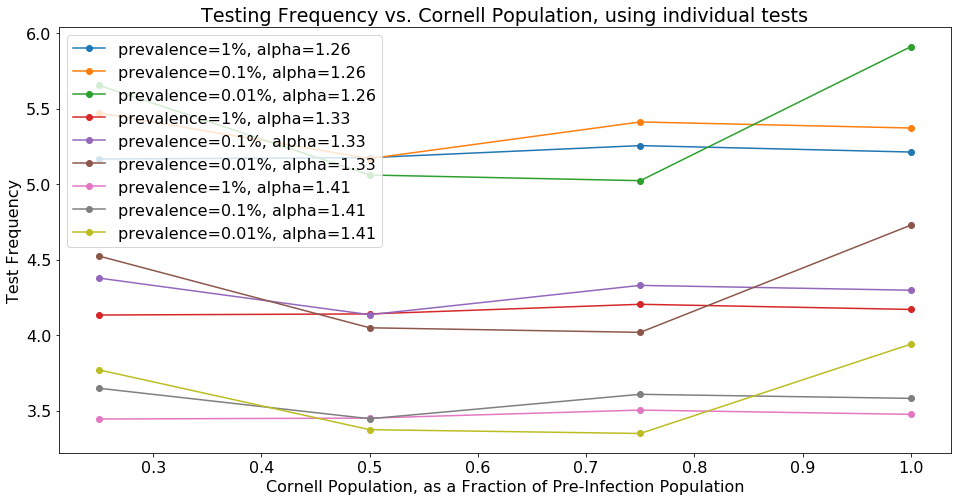

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))
alpha = 2 ** (1/3.0)
alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in [1]:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Frequency vs. Cornell Population, using individual tests")
    for alpha_val, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = fullpop_static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]

                monthly_tests.append(test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha_val))

    plt.xlabel("Cornell Population, as a Fraction of Pre-Infection Population")
    plt.ylabel("Test Frequency")

    plt.legend(loc='best')

        
    


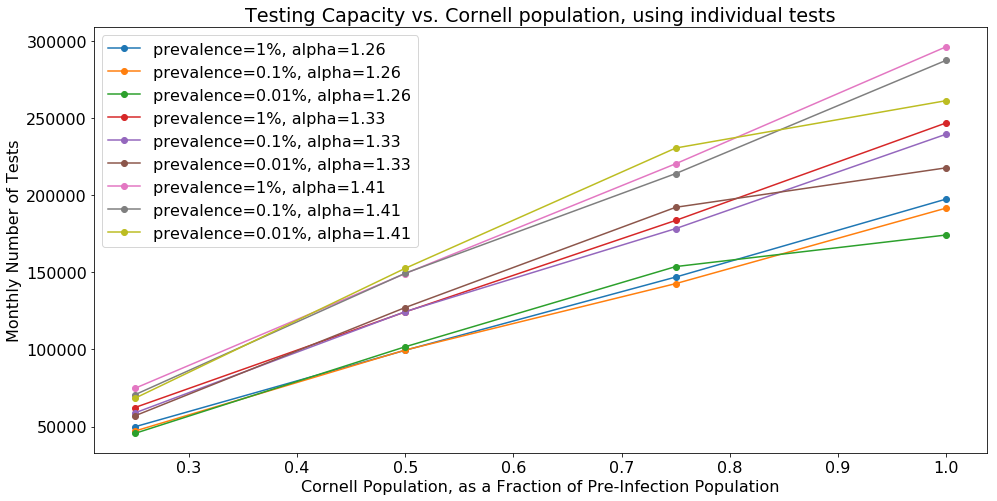

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,36))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 411
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in [1]:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Capacity vs. Cornell population, using individual tests".format(group_size))
    for alpha_val, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = fullpop_static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]
                test_magnitude = fullpop_static_sim_results[(prevalence, reopen_pct, group_size)]['total_tests']

                monthly_tests.append(test_magnitude * 30 / test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha_val))

    plt.xlabel("Cornell Population, as a Fraction of Pre-Infection Population")
    plt.ylabel("Monthly Number of Tests")

    plt.legend(loc='best')

        
    


In [50]:
from group_testing import MatrixGroupTest
from math import sqrt

fullpop_big_mtx_static_sim_results = {}
big_group_sizes = [100, 500, 1000, 5000, 10000]
for prevalence in initial_prevalences:
    for reopen_pct in reopen_pcts:
        for group_size in big_group_sizes:
            n_students = int(reopen_pct * cornellpop)
            pop = Population(n_households=n_students, # Should be big relative to the largest group size
                          household_size_dist=cornell_household_dist,
                          target_prevalence=prevalence,
                          disease_length=0,
                          time_until_symptomatic=0,
                          non_quarantine_alpha=alpha,
                          daily_secondary_attack_rate=SAR,
                          fatality_pct=0,
                          daily_outside_infection_pct=0,
                          outside_symptomatic_prob=0,
                          initial_quarantine=0,
                          initial_prevalence=prevalence)
            test = MatrixGroupTest(int(sqrt(group_size)),FNR,FPR, fnr_at_swab_level=True)
            QFNR, QFPR, tests_per_person, quarantines_per_person = StaticSimulation(pop,test).sim(nreps=100)
            fullpop_big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)] = {
                'QFNR': QFNR, 'QFPR': QFPR, 'tests_per_person':tests_per_person, 
                'total_tests': tests_per_person * n_students, 'quarantines_per_person': quarantines_per_person,
                'total_quarantines': quarantines_per_person * n_students,
                'test_frequency_alpha': frequency(QFNR, alpha, beta),
                'test_frequency_alpha^1.25': frequency(QFNR, alpha**1.25, beta),
                'test_frequency_alpha^1.5':frequency(QFNR,alpha**1.5,beta)
            }
            print("Done static sims for prevalence {} and pct {} and group size {}".format(prevalence, reopen_pct, group_size))


Done static sims for prevalence 0.01 and pct 0.25 and group size 100
Done static sims for prevalence 0.01 and pct 0.25 and group size 500
Done static sims for prevalence 0.01 and pct 0.25 and group size 1000
Done static sims for prevalence 0.01 and pct 0.25 and group size 5000
Done static sims for prevalence 0.01 and pct 0.25 and group size 10000
Done static sims for prevalence 0.01 and pct 0.5 and group size 100
Done static sims for prevalence 0.01 and pct 0.5 and group size 500
Done static sims for prevalence 0.01 and pct 0.5 and group size 1000
Done static sims for prevalence 0.01 and pct 0.5 and group size 5000
Done static sims for prevalence 0.01 and pct 0.5 and group size 10000
Done static sims for prevalence 0.01 and pct 0.75 and group size 100
Done static sims for prevalence 0.01 and pct 0.75 and group size 500
Done static sims for prevalence 0.01 and pct 0.75 and group size 1000
Done static sims for prevalence 0.01 and pct 0.75 and group size 5000
Done static sims for prevalen

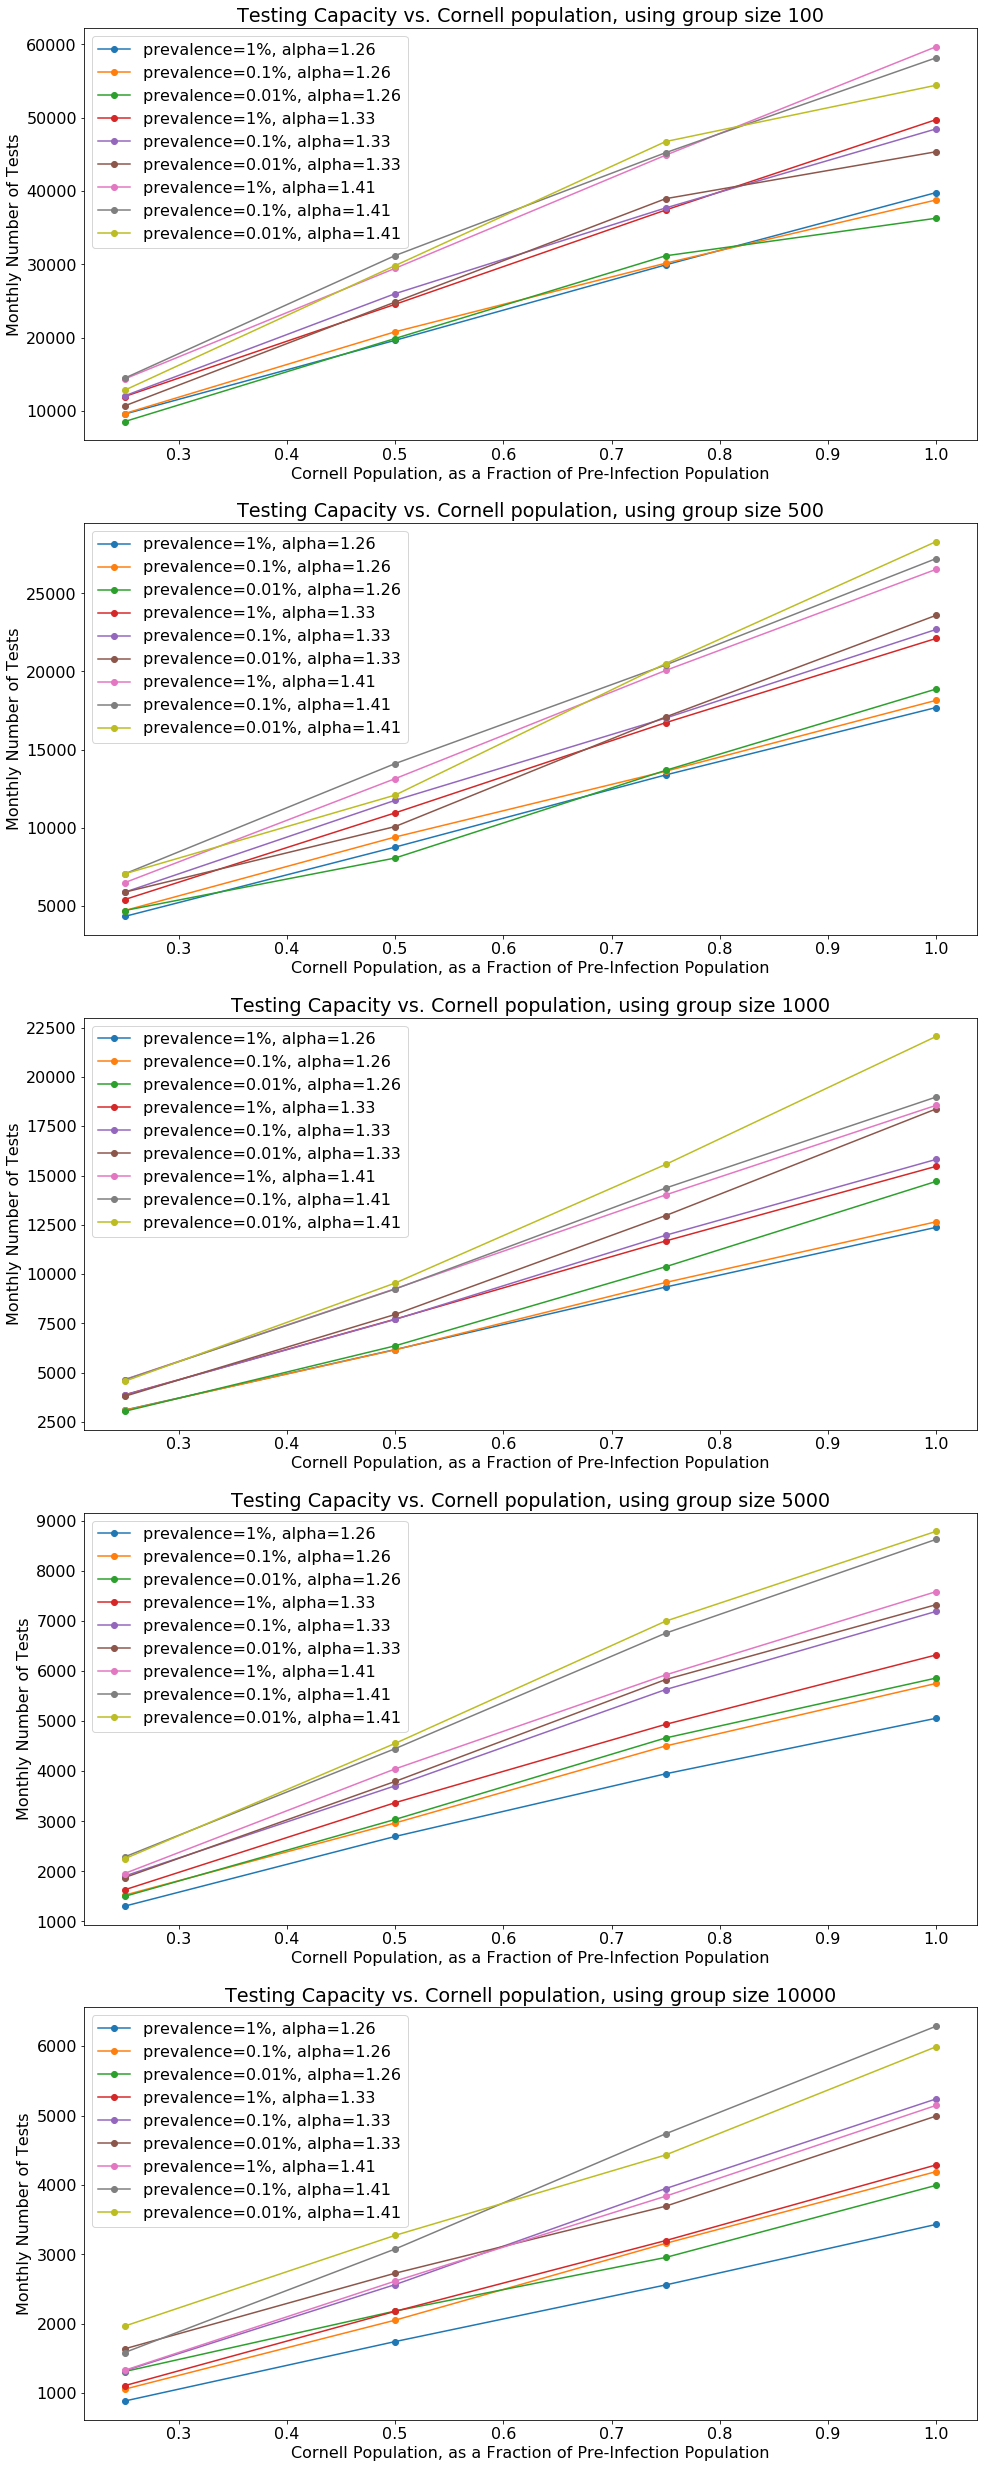

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,44))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 511
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in big_group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Capacity vs. Cornell population, using group size {}".format(group_size))
    for alpha_val, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = fullpop_big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]
                test_magnitude = fullpop_big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)]['total_tests']

                monthly_tests.append(test_magnitude * 30 / test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha_val))

    plt.xlabel("Cornell Population, as a Fraction of Pre-Infection Population")
    plt.ylabel("Monthly Number of Tests")

    plt.legend(loc='best')

        
    


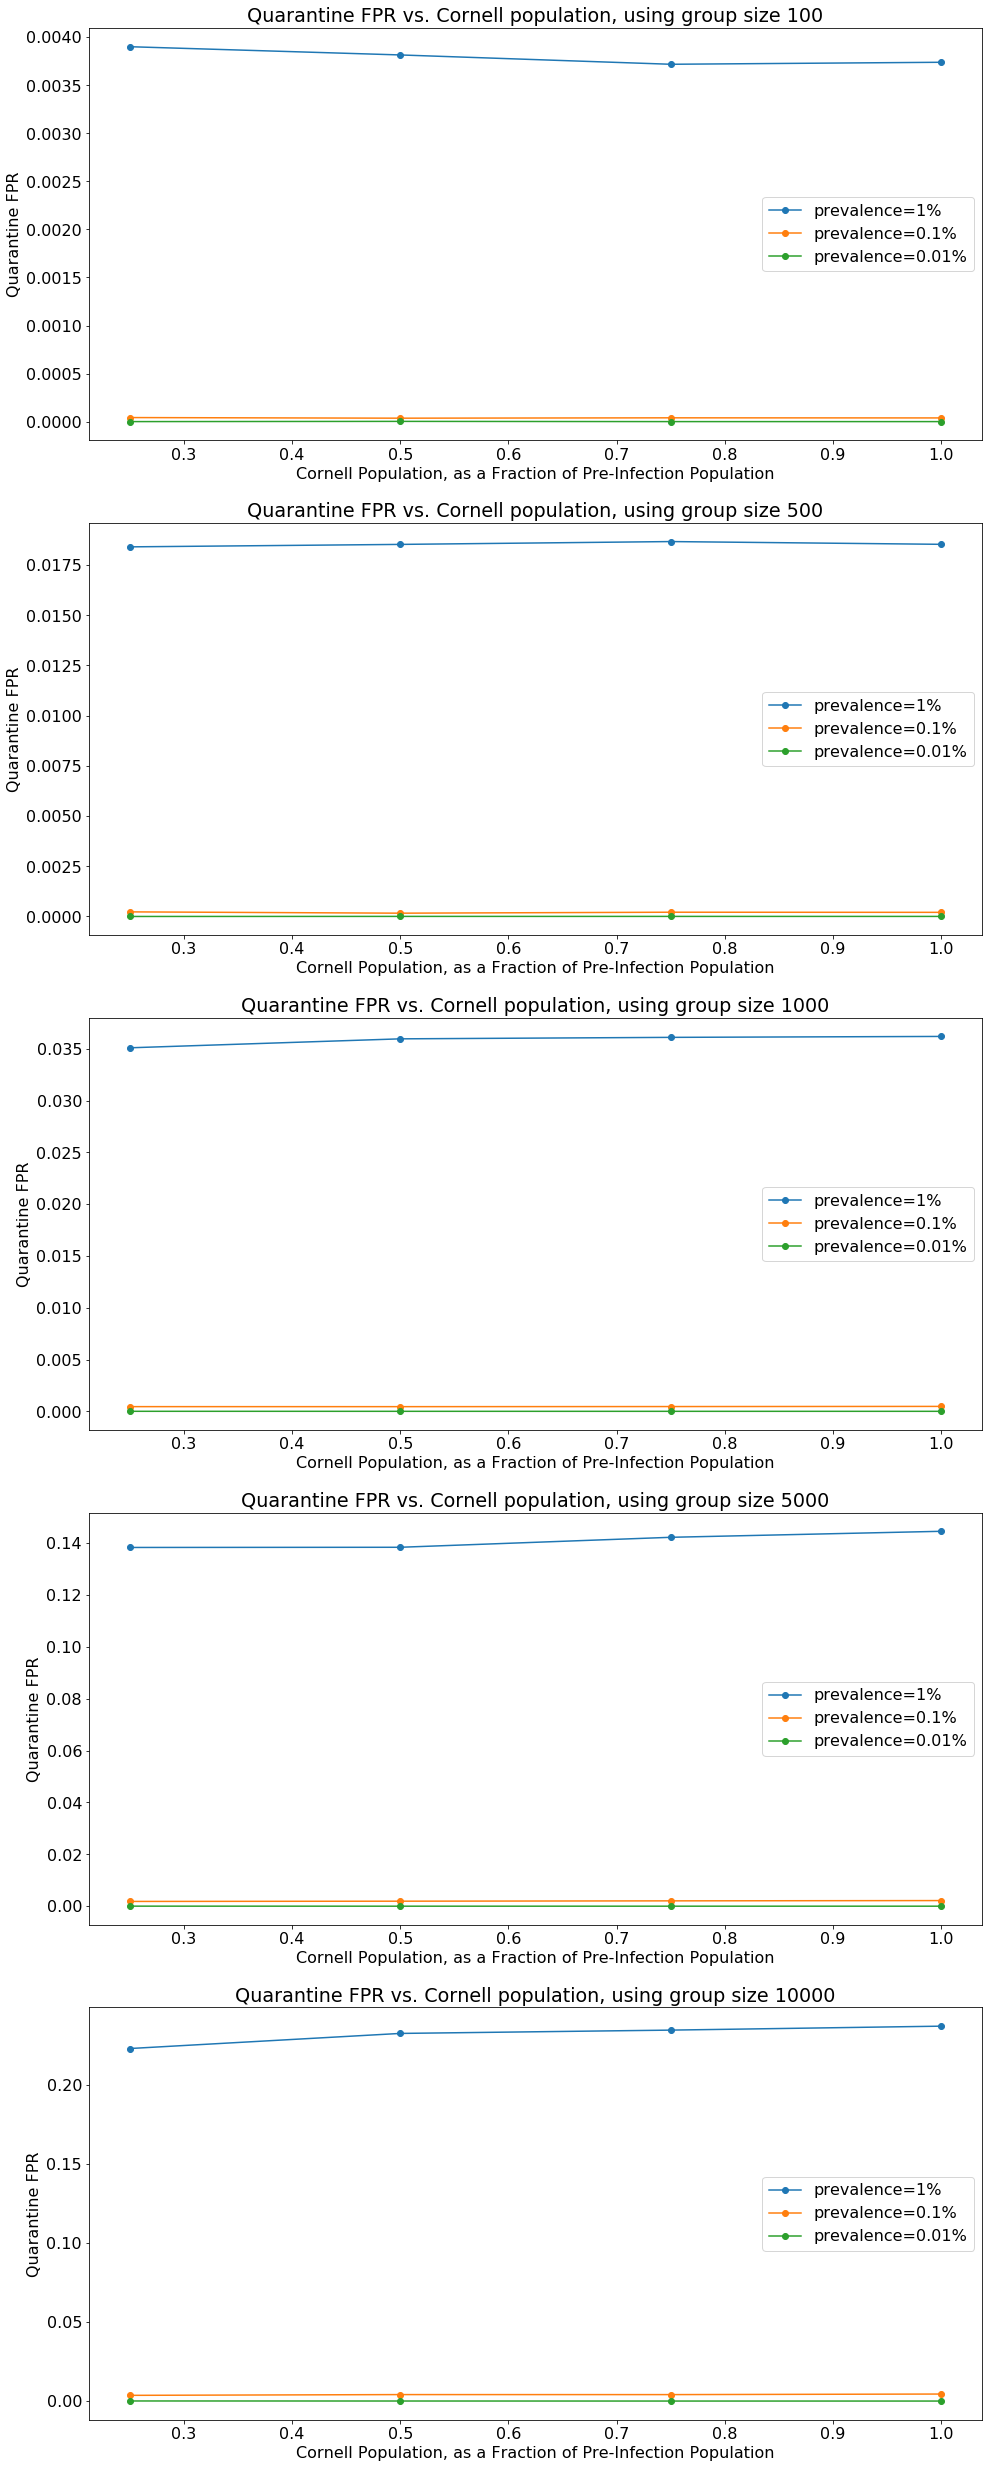

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,44))

alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 511
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in big_group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Quarantine FPR vs. Cornell population, using group size {}".format(group_size))
    

    for prevalence in initial_prevalences:

        monthly_tests = []

        for reopen_pct in reopen_pcts:

            qfpr = fullpop_big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)]['QFPR']

            monthly_tests.append(qfpr)

        plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}".format(
            prevalence_labels[prevalence]))

    plt.xlabel("Cornell Population, as a Fraction of Pre-Infection Population")
    plt.ylabel("Quarantine FPR")

    plt.legend(loc='best')

        
    


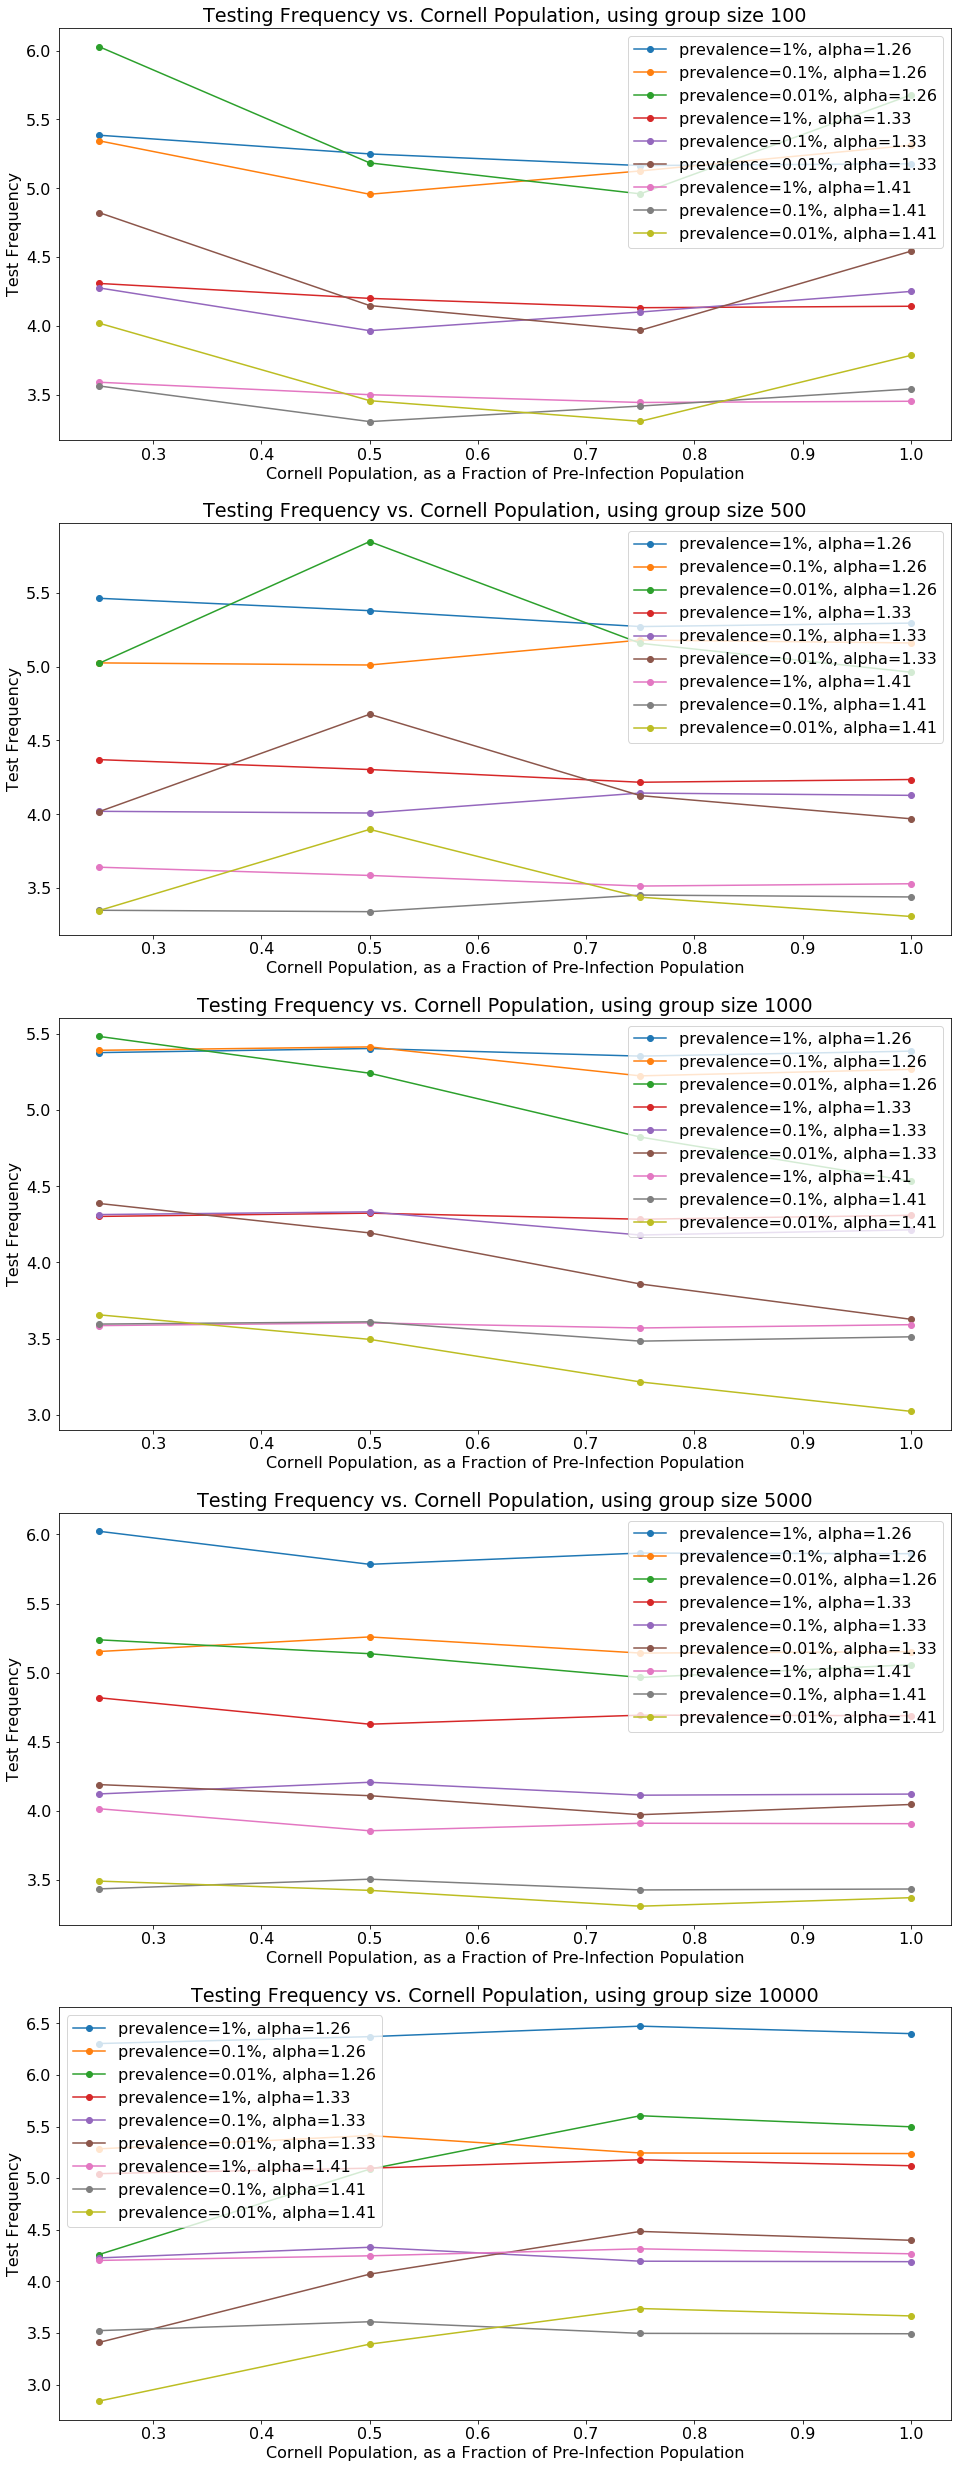

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 16


plt.figure(figsize=(16,44))
alpha = 2 ** (1/3.0)
alpha_keys = {alpha: 'test_frequency_alpha',
               alpha**1.25:'test_frequency_alpha^1.25',
                alpha**1.5:'test_frequency_alpha^1.5'}

subplot_val = 511
prevalence_labels = {0.01: '1%', 0.001: '0.1%', 0.0001: '0.01%'}
for group_size in big_group_sizes:
    plt.subplot(subplot_val)
    subplot_val += 1
    plt.title("Testing Frequency vs. Cornell Population, using group size {}".format(group_size))
    for alpha_val, alpha_key in alpha_keys.items():

        for prevalence in initial_prevalences:

            monthly_tests = []

            for reopen_pct in reopen_pcts:
                test_freq = fullpop_big_mtx_static_sim_results[(prevalence, reopen_pct, group_size)][alpha_key]

                monthly_tests.append(test_freq)

            plt.plot(reopen_pcts, monthly_tests, marker='o', label="prevalence={}, alpha={:.2f}".format(
                prevalence_labels[prevalence], alpha_val))

    plt.xlabel("Cornell Population, as a Fraction of Pre-Infection Population")
    plt.ylabel("Test Frequency")

    plt.legend(loc='best')

        
    
